In [1]:
from pathlib import Path
import sys
 
if sys.argv:
    sys.path.insert(0, str(Path('/Users/ogrobertino/UpliftModelingResearch/').resolve()))
%load_ext autoreload
%autoreload 2
import pandas as pd
from src.datasets import sample_features, TorchDataset, NumpyDataset
from src.global_params import * 
from src.utils import make_stats_table, get_paths_train_test, write_files, write, append_exp
from src.metric import calculate_plot_for_uplift_curve, plot_aucs, get_auuc, plot_uplift_by_percentile_CUM

In [28]:
import json
import os
import pickle
from abc import ABC, abstractmethod
import numpy as np
import pandas as pd
import copy

import time
from catboost import CatBoostClassifier
import causalml
import causalml.metrics as cmetrics
import causalml.inference.tree as ctree
import causalml.inference.meta.tlearner as tlearner
import causalml.inference.meta.slearner as slearner
import causalml.inference.meta.rlearner as rlearner
import causalml.inference.meta.xlearner as xlearner
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier


class IModelUplift(ABC):
    """
    Интерфейс для реализации моделей uplift.
    """

    def __init__(self, config_json=None, from_load=False, path=None):
        if from_load == False:
            if config_json is None:
                raise ValueError(f"No config while contstructing model.")
            self.model = None
            self.config = config_json
        else:
            if path is None:
                raise ValueError(f"No config or model paths while contstructing model.")
            # Дебильный баг, что если сделать self.moldel=loaded_model то models_t,
            #models_s не будут внутри self.model
            model, config = self.load(path)

            self.model = model
            self.config = config

    @abstractmethod
    def fit(self, X: NumpyDataset):
        """
        Метод для обучения модели.
        """
        pass

    @abstractmethod
    def predict(self, X: NumpyDataset):
        """
        Метод для предсказания.
        """
        pass

    @abstractmethod
    def predict_light(self, X: NumpyDataset):
        """
        Метод для предсказания.
        """
        pass

    @abstractmethod
    def load(self, path):
        """
        Метод для конструирования модели из файла.
        """
        pass

    @abstractmethod
    def measure_inference_time(self, data, batch_size, max_size=None):
        """
        Метод для измерения среднего времени инференса модели на данных.
        """
        pass

class ICausalML(IModelUplift):
    def __init__(self, config_json=None, from_load=False, path=None):
        super().__init__(config_json, from_load, path)

    def fit(self, train):
        self.model.fit(
            X=train.data.loc[:, train.cols_features].values,
            treatment=train.data.loc[:, train.col_treatment].values,
            y=train.data.loc[:, train.col_target].values,
        )

    def predict(self, X: NumpyDataset):           
        scores = X.data.copy(deep=True)
        scores['score'] = self.model.predict(scores.loc[:, X.cols_features])
        return scores[['score', col_treatment, col_target]]

    def predict_light(self, X: NumpyDataset):
        self.model.predict(X.data.loc[:, X.cols_features])

    def save(self, path):
        with open(path, 'wb') as f:
            pickle.dump(self, f)
        print(f"Model saved to {path}.")

    def load(self, path):
        config_path = path + "/config.json" 
        model_path = path + "/model.pkl"
        if not os.path.exists(config_path):
            raise ValueError(f"No file found at '{config_path}'.")
        if not os.path.exists(model_path):
            raise ValueError(f"No file found at '{model_path}'.")
        
        with open(model_path, 'rb') as f:
            loaded_model = pickle.load(f)
        with open(config_path, 'rb') as f:
            loaded_config = json.load(f)
            
        print(f"Model loaded from {model_path}.")
        print(f"Config loaded from {config_path}.")

        return loaded_model, loaded_config


    def measure_inference_time(self, data, batch_size, max_size=None):

        batches = [
            data[i:i + batch_size]
            for i in range(0, len(data), batch_size)
        ]
    
        if max_size is None:
            max_size = len(data)
    
        inference_times = []
    
        cur_size = 0
        for batch in batches:
            start_time = time.time()
            predictions = self.predict_light(batch)
            end_time = time.time() 
            
            inference_times.append((end_time - start_time) * 1000 / batch_size)
    
            cur_size += batch_size
            if cur_size >= max_size:
                break
    
        mean_inference_time = np.mean(inference_times)
        return mean_inference_time

# Конкретная реализация модели
class TModel(ICausalML):
    """
    t-моделинг с помощью causalml.
    """

    def __init__(self, config_json=None, from_load=False, path=None):
        super().__init__(config_json, from_load, path)
        self.model = tlearner.BaseTClassifier(
            control_learner=CatBoostClassifier(verbose=0, **self.config['lvl_1']['control']),
            treatment_learner=CatBoostClassifier(verbose=0, **self.config['lvl_1']['treatment']),
            **self.config['lvl_0']['meta']
        )

class IFactory(ABC):
    @staticmethod
    @abstractmethod
    def create():
        """Фабричный метод, создающий объект модели и датасета."""
        pass

class TModelFactory(IFactory):
    @staticmethod
    def create(config_json, train_path, test_path):
        model = TModel(config_json)
        train = NumpyDataset(train_path)
        test = NumpyDataset(test_path)
        return model, train, test

In [29]:
test

In [4]:
config = \
{
  "lvl_0": {
    "meta": {
      "control_name": 0
    }
  },
  "lvl_1": {
    "treatment": {
      "iterations": 20,
      "learning_rate": 0.1,
      "depth": 6,
      "loss_function": "Logloss",
      "eval_metric": "AUC"
    },
    "control": {
      "iterations": 30,
      "learning_rate": 0.05,
      "depth": 4,
      "loss_function": "Logloss",
      "eval_metric": "AUC"
    }
  }
}

In [30]:
def train_test_model(ds_name, features_percent, factory, config, batch_size=32, max_size=100000):
    train_path, test_path = get_paths_train_test(ds_name=ds_name, features_percent=features_percent)
    model, train, test = factory.create(config, train_path, test_path)
    model.fit(train)
    predicted = model.predict(test)
    write(model, test, predicted, ds_name=ds_name, features_percent=features_percent,
          batch_size=batch_size, max_size=max_size)    

In [36]:
train_test_model(ds_name='lazada', features_percent=100, factory=TModelFactory, config=config)

Модель, предсказания и конфиг сохранены в директории path_overall_stats/lazada/100/15
Эксперимент сохранен в таблице ../exps/stats.tsv


In [17]:
train_test_model(ds_name='lazada', features_percent=100, factory=TModelFactory, config=config)

Модель, предсказания и конфиг сохранены в директории path_overall_stats/lazada/100/9


AttributeError: 'NumpyDataset' object has no attribute 'loc'

In [399]:
write(model, predicted, ds_name='lazada', features_percent=100)

Модель, предсказания и конфиг сохранены в директории path_overall_stats/lazada/100/3
Эксперимент сохранен в таблице ../exps/stats.tsv


In [388]:
str(model.__class__.__name__)

'TModel'

In [391]:
kek = pd.read_csv('../exps/stats.tsv')
kek

,Model,Path,Dataset,Features Percent,Latency (ms),Binary Size (MB),AUUC (test),Precision@5,Precision@10,Precision@15,Precision@20,Precision@25,Precision@50,Compressions
0,<class '__main__.TModel'>,path_overall_stats/lazada/100/0,lazada,100,0.063427,0.053735,0.719271,0.003331,0.009578,0.009491,0.009578,0.007752,0.006447,{}
1,TModel,path_overall_stats/lazada/100/1,lazada,100,0.065591,0.053735,0.719271,0.003331,0.009578,0.009491,0.009578,0.007752,0.006447,{}


In [394]:
kek.to_csv("abobus.tsv", sep='\t', index=False)

In [396]:
pd.read_csv("abobus.tsv", sep='\t')

,Model,Path,Dataset,Features Percent,Latency (ms),Binary Size (MB),AUUC (test),Precision@5,Precision@10,Precision@15,Precision@20,Precision@25,Precision@50,Compressions
0,<class '__main__.TModel'>,path_overall_stats/lazada/100/0,lazada,100,0.063427,0.053735,0.719271,0.003331,0.009578,0.009491,0.009578,0.007752,0.006447,{}
1,TModel,path_overall_stats/lazada/100/1,lazada,100,0.065591,0.053735,0.719271,0.003331,0.009578,0.009491,0.009578,0.007752,0.006447,{}


In [262]:
os.path.getsize("../exps/lazada/100/0/model.pkl") / 1e6

0.053735

In [160]:
model2 = TModel(from_load=True, path="../exps/lazada/100/0")

Model loaded from ../exps/lazada/100/0/model.pkl.
Config loaded from ../exps/lazada/100/0/config.json.


   * Назваине модели/класса (. __ class __)
   * Конфиг (гиперпараметры)
   * Название датасета
   * Процент фичей
   * Путь до бинаря модели
   * Время работы (latency)
   * Размер бинаря?
   * AUUC на тесте
   * precision@[5, 100] на тесте

In [263]:
predicted

,score,treatment,target
0,0.045564,1,0
1,0.055329,0,0
2,0.022363,0,0
3,0.010221,1,0
4,0.012022,0,0
...,...,...,...
181664,0.056568,1,1
181665,0.063529,1,0
181666,0.010840,1,0
181667,0.007119,1,0


In [270]:
num_model, uplift_model  = calculate_plot_for_uplift_curve(predicted)
num_random, uplift_random  = calculate_plot_for_uplift_curve(random_scores)

In [268]:
random_scores = predicted.copy(deep=True)
random_scores['score'] = np.random.uniform(0, 1, len(random_scores))

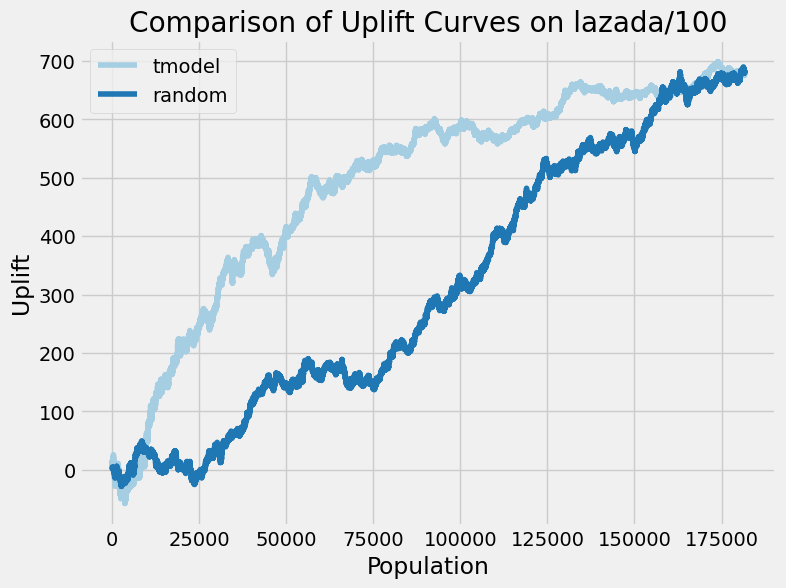

In [277]:
plot_aucs(predicted, random_scores, labels = ['tmodel', 'random'], ds_name='lazada/100')

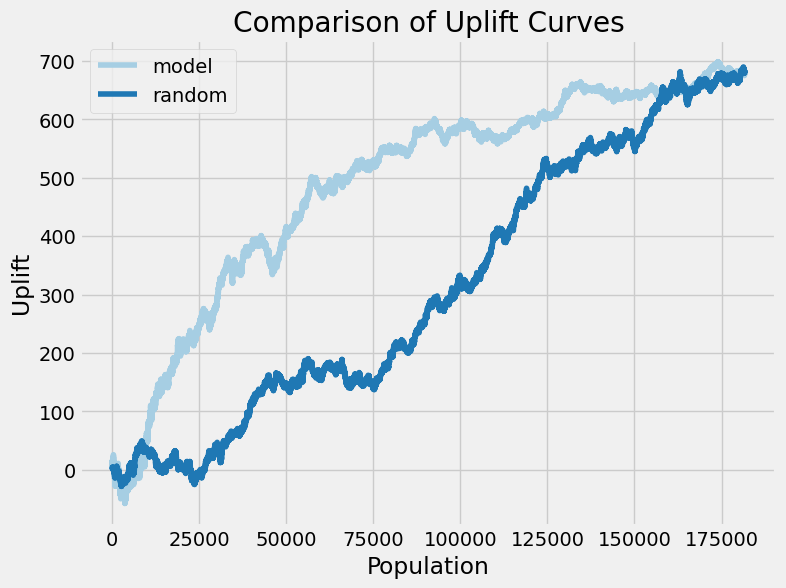

In [271]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
label = "model"
plt.plot(num_model, uplift_model, label=label)
plt.plot(num_random, uplift_random, label="random")
plt.xlabel('Population')
plt.ylabel('Uplift')
plt.title('Comparison of Uplift Curves')
plt.legend()

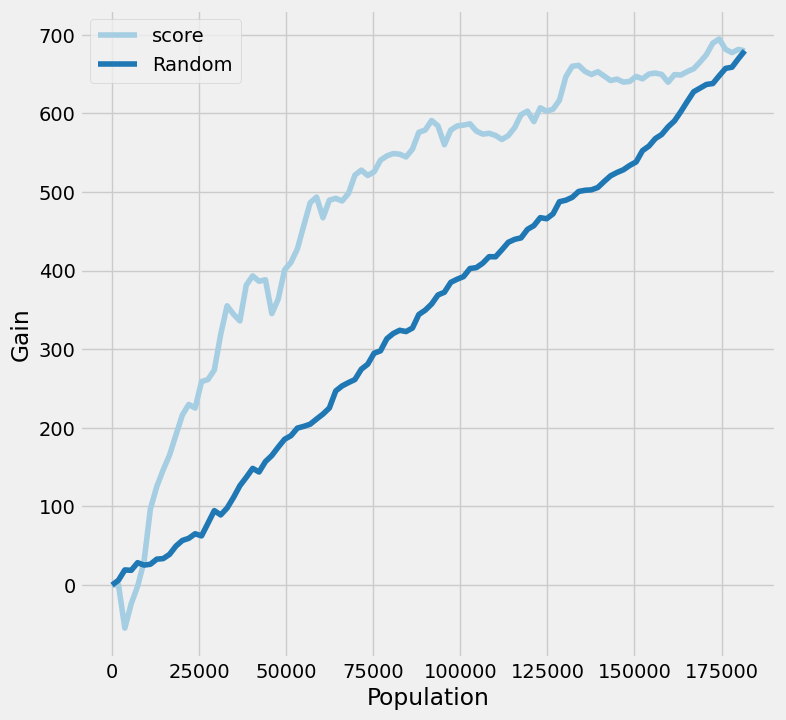

In [272]:
    cmetrics.plot_gain(
        predicted,
        treatment_col=col_treatment,
        outcome_col=col_target,
    )

In [326]:
for k in range(5, 101, 5):
    print(f'"Precision@{k}",')

"Precision@5",
"Precision@10",
"Precision@15",
"Precision@20",
"Precision@25",
"Precision@30",
"Precision@35",
"Precision@40",
"Precision@45",
"Precision@50",
"Precision@55",
"Precision@60",
"Precision@65",
"Precision@70",
"Precision@75",
"Precision@80",
"Precision@85",
"Precision@90",
"Precision@95",
"Precision@100",


In [327]:
pd.DataFrame(columns=[
    'Model',
    'Path',
    'Dataset',
    'Features Percent',
    'Latency (ms)',
    'Binary Size (MB)',
    "AUUC (test)",
    "Precision@5",
    "Precision@10",
    "Precision@15",
    "Precision@20",
    "Precision@25",
    "Precision@50",
    "Compressions"    
])

,Model,Path,Dataset,Features Percent,Latency (ms),Binary Size (MB),AUUC (test),Precision@5,Precision@10,Precision@15,Precision@20,Precision@25,Precision@50,Compressions


In [55]:
pd.DataFrame([{
        "Model/Class": model.__class__.__name__,
        "Config": config,
        "Dataset Name": dataset_name,
        "Features Percent": features_percent,
        "Model Path": model_binary_path,
        "Latency (ms)": latency,
        "Binary Size (KB)": binary_size,
        "AUUC (test)": auuc_test,
        "Precision@[5,100]": precision_at_k
    }])

NameError: name 'dataset_name' is not defined